--- 
description: Here we show how to solve graph isomorphisms problem using JijZept and JijModeling.
---

# Graph Isomorphisms problem

Here we show how to solve graph isomorphisms problem using JijZept and [JijModeling](https://www.ref.documentation.jijzept.com/jijmodeling/). 
This problem is also mentioned in 9. Graph Isomorphisms on [Lucas, 2014, "Ising formulations of many NP problems"](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full).

## What is Graph Isomorphisms Problem?

Graph isomorphism is a concept that describes when two graphs $G_1$ and $G_2$ have the same structure, meaning that they have the same $N$ number of vertices and edges and that their vertices and edges are arranged in the same way.
More carefully: identical graphs are any graph $G = (V, E)$ with vertices labeled as $1,\cdots,N$ and with an $N \times N$ adjacency matrix $A$ with
$$
A_{ij} \equiv \begin{cases}
    1 & \text{if } (ij) \in E \\
    0 & \text{if } (ij) \notin E
\end{cases}
$$
which contains all information about the edge set $E$.

## Mathematical Model

First, we introduce binary variables $x_{v, i}$ which are 1 if vertex $v$ in $G_2$ gets mapped to vertex $i$ in $G_1$ and 0 otherwise.

### Constraint 1: the map is bijective

A bijective map between two graphs is a one-to-one correspondence between the vertices of the two graphs, such that each vertex in one graph is paired with a unique vertex in the other graph.

$$
\quad \sum_{i}x_{v,i} = 1 \quad  (\forall v) \tag{1} $$
$$\quad \sum_{v}x_{v,i} = 1 \quad  (\forall i) \tag{2}
$$

### Constraint 2: no bad mapping exists

An edge that is not in $G_1$ but is in $G_2$, or an edge that is in $G_1$ but is not in $G_2$ should not exist.
$$
\quad \sum_{ij \notin E_1}\sum_{uv \in E_2} x_{u,i}x_{v,j}+\sum_{ij \in E_1}\sum_{uv \notin E_2} x_{u,i}x_{v,j} = 0\tag{3}
$$


## Modeling by JijModeling

Next, we show an implementation using JijModeling. We first define variables for the mathematical model described above.

In [1]:
import jijmodeling as jm

#define variables
V = jm.Placeholder('V')  # number of vertices
E1 = jm.Placeholder('E1', ndim=2)  # set of edges
E2 = jm.Placeholder('E2', ndim=2)  # set of edges
E1_bar = jm.Placeholder('E1_bar', ndim=2)
E2_bar = jm.Placeholder('E2_bar', ndim=2)

x = jm.BinaryVar('x',shape=(V,V))
i = jm.Element('i', belong_to=(0, V))
j = jm.Element('j', belong_to=(0, V))
u = jm.Element('u', belong_to=(0, V))
v = jm.Element('v', belong_to=(0, V))
e1 = jm.Element('e1', belong_to=E1)
e2 = jm.Element('e2', belong_to=E2)
f1 = jm.Element('f1', belong_to=E1_bar)
f2 = jm.Element('f2', belong_to=E2_bar)

We use the same variables in the graph ordering problem.

### Constraint

We implement the constraint equations.

In [2]:
# set problem
problem = jm.Problem('Graph Isomorphisms')
# set constraint
problem += jm.Constraint('const1-1', x[v, :].sum()==1, forall=v)
problem += jm.Constraint('const1-2', x[:, i].sum()==1, forall=i)
const1 = jm.sum([f1, e2], x[e2[0],f1[0]]*x[e2[1],f1[1]])
const2 = jm.sum([e1, f2], x[f2[0],e1[0]]*x[f2[1],e1[1]])
problem += jm.Constraint('const2', const1 + const2==0)

Let's display the implemented mathematical model in Jupyter Notebook.

In [3]:
problem

## Prepare an instance

We prepare a graph using [Networkx](https://networkx.org/).

In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# First graph
graph1 = [[0, 1, 0, 1],
          [1, 0, 1, 0],
          [0, 1, 0, 1],
          [1, 0, 1, 0]]

# Second graph
graph2 = [[0, 0, 1, 1],
          [0, 0, 1, 1],
          [1, 1, 0, 0],
          [1, 1, 0, 0]]

# Create networkx graphs from adjacency matrices
G1 = nx.from_numpy_array(np.array(graph1))
G2 = nx.from_numpy_array(np.array(graph2))

num_V = G1.number_of_nodes()

edges1 = G1.edges()
inst_E1 = [list(edge) for edge in edges1]

edges2 = G2.edges()
inst_E2 = [list(edge) for edge in edges2]

non_edges1 = list(nx.non_edges(G1))
inst_E1_bar = [list(non_edge) for non_edge in non_edges1]

non_edges2 = list(nx.non_edges(G2))
inst_E2_bar = [list(non_edge) for non_edge in non_edges2]

instance_data = {'V': num_V, 'E1': inst_E1, 'E2': inst_E2, 'E1_bar': inst_E1_bar, 'E2_bar': inst_E2_bar}


The input graphs are shown below.

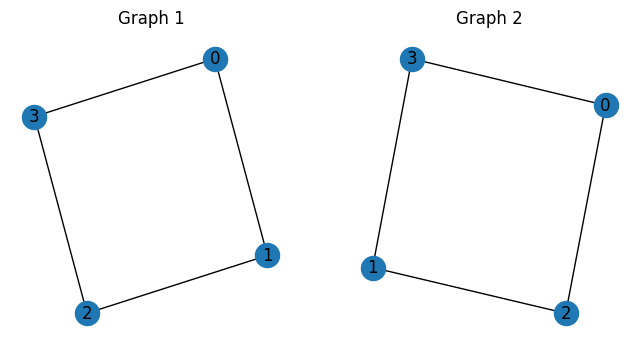

In [5]:
# Create figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Draw graphs
nx.draw(G1, ax=axs[0], with_labels=True)
axs[0].set_title("Graph 1")
nx.draw(G2, ax=axs[1], with_labels=True)
axs[1].set_title("Graph 2")

# Show the plot
plt.show()


## Solve by JijZept's SA

We solve this problem using JijZept `JijSASampler`. We also use the parameter search function by setting `search=True`.

In [6]:
import jijzept as jz

# set sampler
sampler = jz.JijSASampler(config="./config.toml")
# solve problem
multipliers = {'const1-1': 0.3, 'const1-2': 0.3, 'const2': 0.3}
results = sampler.sample_model(problem, instance_data, multipliers, num_reads=100, search=True)

## Check solution

In the end, we extract the lowest energy solution from the feasible solutions and check it.

In [7]:
# extract feasible solution
feasible = results.feasible()
if feasible.evaluation.objective.size == 0:
    print('No feasible solution found ...')
else:
    print("Objective: "+str(feasible.evaluation.objective[0]))
    # get indices of x = 1
    indices, _, _ = feasible.record.solution['x'][0]
    # get vertex number and order
    vertices, orders = indices
    print(f'vertex: {vertices}')
    print(f'orders: {orders}')

Objective: 0.0
vertex: [0, 2, 3, 1]
orders: [0, 3, 1, 2]


As we expected, JijZept successfully shows that it is isomorphic.